In [ ]:
# PyTorch 套件 (深度學習核心)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.transforms import Resize
from torchsummary import summary  # 模型結構摘要

# 資料處理與數學運算
import pandas as pd
import numpy as np
import math
import random
from pathlib import Path
from scipy.spatial.distance import directed_hausdorff
import sys

# 影像處理相關套件
import imageio.v2 as imageio
from skimage.io import imread, imshow
from skimage.transform import rescale
import cv2 as cv

# 繪圖與顯示
import matplotlib.pyplot as plt
from tqdm import tqdm  # 進度條
from IPython.core.debugger import set_trace  # 除錯工具

# Google Colab 相關 (若非在 Colab 執行，可刪除)
try:
    from google.colab import drive
    from google.colab.patches import cv2_imshow  # 顯示 OpenCV 影像 (Colab)
    drive.mount('/content/drive')
except ImportError:
    cv2_imshow = cv.imshow  # 非 Colab 則使用 OpenCV 標準顯示函數

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class FetalHCDataset(Dataset):
    def __init__(self, dataset_dir, img_scale = None, train = True, transform = True):
        dataset_dir = Path(dataset_dir) # 'drive/My Drive/HC_Dataset'
        self.img_scale = img_scale
        self.transform  = transform
        if train == True:
            self.data_details_frame = pd.read_csv(dataset_dir / 'trainset' / 'trainset.csv')
            self.imgs_dir =  dataset_dir / 'trainset' / 'imgs'
            self.masks_dir = dataset_dir / 'trainset' / 'masks'
        else:
            self.data_details_frame = pd.read_csv(dataset_dir / 'testset' / 'testset.csv')
            self.imgs_dir =  dataset_dir / 'testset' / 'imgs'
            self.masks_dir = dataset_dir / 'testset' / 'masks'

    def __len__(self):
        return len(self.data_details_frame)

    def __getitem__(self, idx):
        img_file = self.imgs_dir / self.data_details_frame.iloc[idx, 0]
        img = imread(img_file)

        mask_file = self.masks_dir / f'{img_file.stem}_Annotation.png'
        mask = imread(mask_file)

        img_details = self.data_details_frame.iloc[idx, 1:3]
        img_details = img_details.values.astype(np.float32) #series to numpy

        ellipse_parameters = self.data_details_frame.iloc[idx, 3:]
        ellipse_parameters = ellipse_parameters.values.astype(np.float32)

        sample = {'img' : img,
                       'mask' : mask,
                       'img_details': img_details,
                       'ellipse_parameters' : ellipse_parameters
                  }

        if self.transform == True:
            sample = self.trans(sample)

        return sample

    def trans(self, sample):
        if self.img_scale: #rescale會把255 -> 1
            sample['img']   = rescale(sample['img'], scale=(self.img_scale, self.img_scale))
            sample['mask'] = rescale(sample['mask'], scale=(self.img_scale, self.img_scale))
        '''HW 轉 CHW 再轉乘 tensor'''
        sample['img']           = torch.from_numpy(sample['img'][np.newaxis, :])
        sample['mask']         = torch.from_numpy(sample['mask'][np.newaxis, :])
        sample['img_details'] = torch.from_numpy(sample['img_details'])
        '''正規化橢圓參數[0, 1]'''
        sample['ellipse_parameters'][0] = (sample['ellipse_parameters'][0]/800)
        sample['ellipse_parameters'][1] = (sample['ellipse_parameters'][1]/540)
        sample['ellipse_parameters'][2] = (sample['ellipse_parameters'][2]/800)
        sample['ellipse_parameters'][3] = (sample['ellipse_parameters'][3]/540)
        sample['ellipse_parameters'][4] = (sample['ellipse_parameters'][4]/3.14)
        sample['ellipse_parameters'] = torch.from_numpy(sample['ellipse_parameters'])

        return sample

filename          000_HC.png
center_x_mm        93.899184
center_y_mm        66.609172
semi_axes_a_mm      54.60078
semi_axes_b_mm     39.444728
angle_rad            3.07701
Name: 0, dtype: object


tensor([ 0.0691, 44.3000])
tensor(409.4313)
tensor(377.7873)
tensor(187.8440)
tensor(223.8851)
tensor(23.7063)
ellipse fitting: 89.768


<ipython-input-38-0a0ae63863a0>:30: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  plt.subplot(1,2,1), imshow(img)
<ipython-input-38-0a0ae63863a0>:32: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  plt.subplot(1,2,2), imshow(mask)


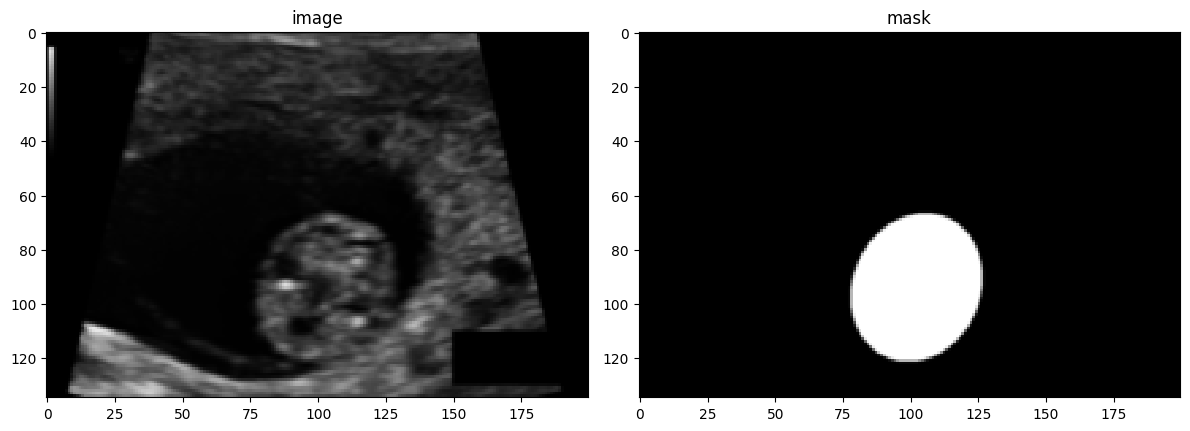

In [ ]:
'''第幾row的資料'''
i = 0

'''測試資料是否正常顯示'''
trainset = FetalHCDataset('drive/My Drive/HC_Dataset', img_scale = 0.5, train = True, transform = True)
data = trainset[i]
'''pd 讀取'''
data_frame = pd.read_csv('drive/My Drive/HC_Dataset/trainset/trainset.csv')
print(data_frame.iloc[i])

print('\n')
''''dataloader還原'''
print(data['img_details'])
print(data['ellipse_parameters'][0]*800)
print(data['ellipse_parameters'][1]*540)
print(data['ellipse_parameters'][2]*800)
print(data['ellipse_parameters'][3]*540)
print(data['ellipse_parameters'][4]*3.14)

pixel_size = data['img_details'][0]
a = data['ellipse_parameters'][2]*800
b = data['ellipse_parameters'][3]*540

HC = math.sqrt((math.pow(a*pixel_size, 2) + math.pow(b*pixel_size, 2))/2) * 2 * np.pi
print(f'ellipse fitting: {HC:.3f}')

img = data['img'].squeeze().numpy()
mask = data['mask'].squeeze().numpy()
plt.rcParams['figure.figsize'] = [12, 8]
plt.subplot(1,2,1), imshow(img)
plt.title('image')
plt.subplot(1,2,2), imshow(mask)
plt.title('mask')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1, dropout_p=0.3):
        super().__init__()
        self.n = n #重複做幾次conv+BN+RELU
        self.ks = ks #kernel size default:3x3
        self.dropout = nn.Dropout2d(p=dropout_p)
        if is_batchnorm:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, stride, padding),
                                     nn.BatchNorm2d(out_size),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        else:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, stride, padding),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size


    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n + 1):
            conv = getattr(self, 'conv%d' % i)
            x = conv(x)
            x = self.dropout(x)

        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1, is_batchnorm=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.is_batchnorm = is_batchnorm
        filters = [32, 64, 128, 256, 512]

        # downsampling
        self.conv1 = unetConv2(self.n_channels, filters[0], self.is_batchnorm)
        self.maxpool = nn.MaxPool2d(kernel_size=2)

        self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)

        self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)

        self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)

        self.conv5 = unetConv2(filters[3], filters[4], self.is_batchnorm)

        # upsampling
        self.up_4 = unetConv2(filters[4]+filters[3], filters[3], self.is_batchnorm)
        self.up_3 = unetConv2(filters[3]+filters[2], filters[2], self.is_batchnorm)
        self.up_2 = unetConv2(filters[2]+filters[1], filters[1], self.is_batchnorm)
        self.up_1 = unetConv2(filters[1]+filters[0], filters[0], self.is_batchnorm)
        self.outconv1 = nn.Conv2d(filters[0], 1, 3, padding=1)

    def forward(self, inputs):

        def samesize(targetsize, *xtuple):
            outputx = []
            outputx.append(targetsize)
            for x in xtuple:
                outputx.append(F.interpolate(x, targetsize.shape[2:], mode = 'bilinear', align_corners = True))
            return tuple(outputx)

        h1 = self.conv1(inputs)  #64*270*400
       # self.featuremap1 = h1.detach() # 查看第1層特徵圖前10張輸出樣貌

        h2 = self.conv2(self.maxpool(h1)) #128*135*200
      #  self.featuremap2 = h2.detach() # 查看第2層特徵圖輸出樣貌

        h3 = self.conv3(self.maxpool(h2))  #256*67*100
      #  self.featuremap3 = h3.detach() # 查看第3層特徵圖輸出樣貌

        h4 = self.conv4(self.maxpool(h3))  #512*33*50
       # self.featuremap4 = h4.detach() # 查看第4層特徵圖輸出樣貌

        h5 = self.conv5(self.maxpool(h4))  #1024*16*25
        # self.featuremap5 = h5.detach() # 查看第5層特徵圖輸出樣貌

        hd4 = self.up_4(torch.cat(samesize(h4, h5), 1))  # 512*33*50
        hd3 = self.up_3(torch.cat(samesize(h3, hd4), 1))  # 256*67*100
        hd2 = self.up_2(torch.cat(samesize(h2, hd3), 1))  # 128*135*200
        hd1 = self.up_1(torch.cat(samesize(h1, hd2), 1))  # 64*270*400

        d1 = self.outconv1(hd1)  # 256
        return d1

In [ ]:
net = UNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
summary(net, input_size=(1, 200, 135)) # CHW
# 270 135  67 33

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 200, 135]             320
       BatchNorm2d-2         [-1, 32, 200, 135]              64
              ReLU-3         [-1, 32, 200, 135]               0
         Dropout2d-4         [-1, 32, 200, 135]               0
            Conv2d-5         [-1, 32, 200, 135]           9,248
       BatchNorm2d-6         [-1, 32, 200, 135]              64
              ReLU-7         [-1, 32, 200, 135]               0
         Dropout2d-8         [-1, 32, 200, 135]               0
         unetConv2-9         [-1, 32, 200, 135]               0
        MaxPool2d-10          [-1, 32, 100, 67]               0
           Conv2d-11          [-1, 64, 100, 67]          18,496
      BatchNorm2d-12          [-1, 64, 100, 67]             128
             ReLU-13          [-1, 64, 100, 67]               0
        Dropout2d-14          [-1, 64, 

In [ ]:
'''訓練途中看看模型的效能如何'''
def eval_net(net, loader, device):
    net.eval()

    n_val = len(loader)  # the number of batch

    tot_bce_loss = 0
    bce_criterion = nn.BCEWithLogitsLoss()

    with tqdm(total=n_val, desc='正在評估(Test Data)', unit='batch', leave = False) as pbar:
        for batch in loader:
            imgs, true_masks = batch['img'], batch['mask']
            imgs = imgs.to(device=device, dtype=torch.float32)
            true_masks = true_masks.to(device=device, dtype=torch.float32)

            with torch.no_grad():
                pred_masks = net(imgs)

                '''計算BCE loss'''
                bce_loss = bce_criterion(pred_masks, true_masks).item()
                tot_bce_loss += bce_loss

                pbar.set_postfix(**{'bce loss (batch)': bce_loss})
                pbar.update()

    net.train()
    return tot_bce_loss / n_val

**開始訓練**


---



In [ ]:
dir_checkpoint  = 'drive/My Drive/Colab Notebooks/HC_Dataset/Unet_checkpoints'
HC_Dataset_dir = 'drive/My Drive/Colab Notebooks/HC_Dataset'

def train_net(net, device, epochs=20, batch_size=8, lr=0.0001, save_cp=True, img_scale=0.5):

    trainset = FetalHCDataset(HC_Dataset_dir, img_scale = img_scale ,train = True,  transform = True)
    testset =  FetalHCDataset(HC_Dataset_dir, img_scale = img_scale ,train = False, transform = True)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    testloader =  DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, drop_last=True)

    n_val = len(testset)
    n_train = len(trainset)

    print(f"\nStarting training:\n \
        Epochs:          {epochs}\n \
        Batch size:      {batch_size}\n \
        Learning rate:   {lr}\n \
        Training size:   {n_train}\n \
        Validation size: {n_val}\n \
        Checkpoints:     {save_cp}\n \
        Device:          {device.type}\n \
        Images scaling:  {img_scale}\n \
    ")

    net.to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    global_step = 0

    for epoch in range(epochs):
        net.train()
        with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
            for batch in trainloader:
                imgs = batch['img']
                true_masks = batch['mask']

                imgs = imgs.to(device=device, dtype=torch.float32)
                true_masks = true_masks.to(device=device, dtype=torch.float32)

                pred_masks = net(imgs)
                loss =  criterion(pred_masks, true_masks)

                pbar.set_postfix(**{'loss (batch)': loss.item()})
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                pbar.update(imgs.shape[0])

                global_step += 1
                if global_step % (n_train // (batch_size * 10)) == 0:
                    val_score = eval_net(net, testloader, device)
                    print(f"---current learning rate : {optimizer.param_groups[0]['lr']}")
                    print(f'BCE loss  : {val_score[1]:.6f}\n')
        if save_cp:
                if not Path(dir_checkpoint).exists():
                    Path(dir_checkpoint).mkdir(exist_ok=True)
                    print('Created checkpoint directory')

                torch.save(net.state_dict(), dir_checkpoint + f'/CP_epoch{epoch + 1}.pth')
                print(f'Checkpoint {epoch + 1} saved !')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet()

train_net(net = net, device = device, epochs= 40, img_scale= 0.25, batch_size=8, lr=0.001)



Starting training:
         Epochs:          40
         Batch size:      8
         Learning rate:   0.001
         Training size:   799
         Validation size: 200
         Checkpoints:     True
         Device:          cuda
         Images scaling:  0.25
     


Epoch 1/40:   9%|▉         | 72/799 [01:17<13:05,  1.08s/img, loss (batch)=-129]

---current learning rate : 0.001


TypeError: 'float' object is not subscriptable

**定義函數**


---



In [ ]:
dir_checkpoint  = 'drive/My Drive/HC_Dataset/Unet_checkpoints'
HC_Dataset_dir = 'drive/My Drive/HC_Dataset'

epoch = '40'
def dicecoeff(input, target):
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()

    return ((2. * intersection ) / (iflat.sum() + tflat.sum()))

def predict(img,  device):
    net = UNet()
    net.load_state_dict(torch.load(dir_checkpoint + f'/CP_epoch{epoch}.pth'))
    net.to(device)

    net.eval()
    img = torch.from_numpy(img[np.newaxis, :])
    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)
    with torch.no_grad():
        predicted = net(img)
        outputs = []
        probs = torch.sigmoid(predicted).squeeze().cpu().numpy()
    return probs>0.5

**資料測試**


---



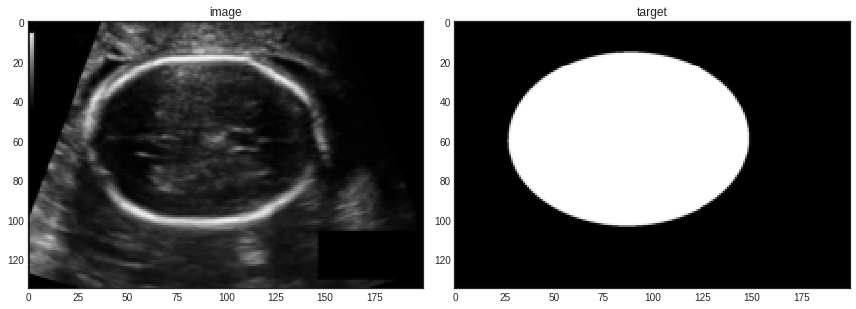

In [ ]:
''''testset 資料測試'''

test_num = 100

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

testset = FetalHCDataset(HC_Dataset_dir , img_scale = 0.25, train = False, transform = True)
data = testset[test_num]

img = data['img'].squeeze().numpy()
mask = data['mask'].squeeze().numpy()

plt.rcParams['figure.figsize'] = [12, 8]
plt.subplot(1,2,1), imshow(img)
plt.title('image')
plt.subplot(1,2,2), imshow(mask)
plt.title('target')
plt.show()

**模型預測輸出**

---



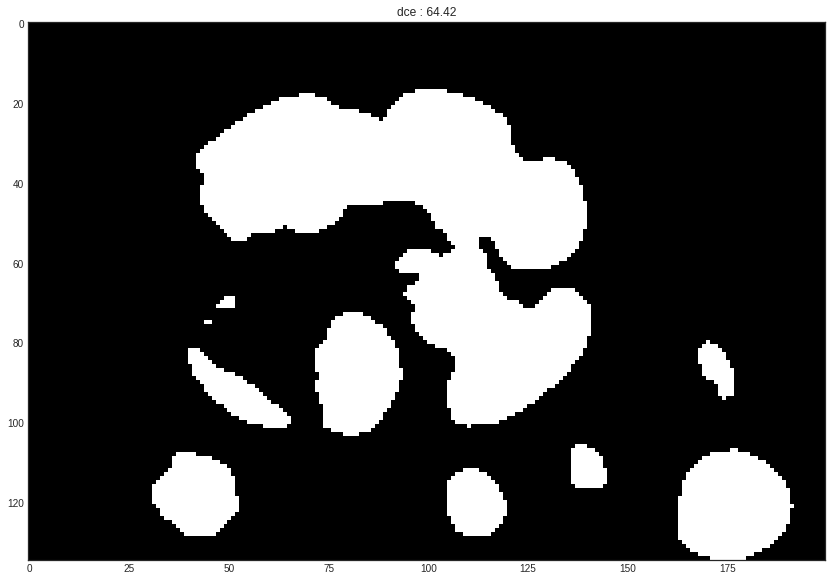

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
predicted = predict(img, device)

'''神經網路輸出結果'''
imshow(predicted)
dice_score = dicecoeff(torch.from_numpy(predicted), torch.from_numpy(mask)) * 100

plt.title(f'dce : {dice_score:.2f}')
plt.show()

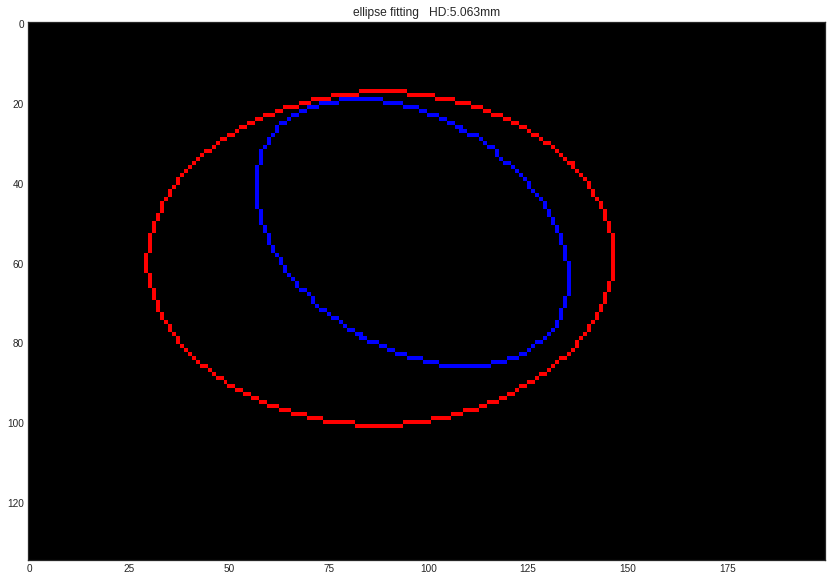

LABEL HC  :  160.210  mm
PREDICT HC:  111.263  mm
---------------------------------------------
Dice:  64.42   %
HD :   5.06   mm
DF :  48.95   mm
ADF:  48.95   mm


In [ ]:
pixel_size = data['img_details'][0].item()
HC_label = data['img_details'][1].item()

predictx = predicted
predictx = predictx.astype(np.uint8)

'''取橢圓擬合結果'''
predict_contours, _= cv.findContours(predictx, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
list_contours_pixels_num = list(map(lambda x: len(x), predict_contours))
max_idx = list_contours_pixels_num.index(max(list_contours_pixels_num))
predict_contour = predict_contours[max_idx]

mask_ori = mask
mask_ori = mask_ori.astype(np.uint8)
mask_contours, hierarchy = cv.findContours(mask_ori, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

mask_contour = mask_contours[0]

distance_a = directed_hausdorff(predict_contour.reshape(-1,2), mask_contour.reshape(-1,2))
distance_b = directed_hausdorff(mask_contour.reshape(-1,2), predict_contour.reshape(-1,2))
HD = max(distance_a[0], distance_b[0])*pixel_size

paper = np.zeros_like(predictx)
paper = cv.cvtColor(paper,cv.COLOR_GRAY2RGB)
cv.drawContours(paper,mask_contour,-1,(255,0,0),1) #紅色是答案
# cv.drawContours(paper,predict_contour,-1,(0,255,0),1) #綠色是預測

# ellipse = cv.fitEllipse(predict_contour)
ellipsedirect = cv.fitEllipseDirect(predict_contour)


# cv.ellipse(paper, ellipse, (0,0,255), 1) #藍色是橢圓擬合結果
cv.ellipse(paper, ellipsedirect, (0,0,255), 1) #藍色是橢圓擬合結果

imshow(paper)
plt.title(f'ellipse fitting   HD:{HD:.3f}mm')
plt.show()

xc  = ellipsedirect[0][0]
yc  = ellipsedirect[0][1]
b   = ellipsedirect[1][0] / 2 * pixel_size
a   = ellipsedirect[1][1] / 2 * pixel_size
theta = math.radians((ellipsedirect[2] + 90)%180)

predict_HC = 2 * np.pi * math.sqrt((math.pow(a, 2) + math.pow(b, 2))/2)
predict_HC = predict_HC*4

print(f'LABEL HC  : {HC_label:^10.3f}mm')
print(f'PREDICT HC: {predict_HC:^10.3f}mm')
print('---------------------------------------------')
DF = HC_label - predict_HC
ADF = abs(HC_label - predict_HC)
print(f'Dice:{dice_score:^10.2f}%')
print(f'HD :{HD:^10.2f}mm')
print(f'DF :{DF:^10.2f}mm')
print(f'ADF:{ADF:^10.2f}mm')

**以下是挑戰賽**


---



In [ ]:
class FetalHCValidDataset(Dataset):
    def __init__(self, dataset_dir, img_scale = None, transform = True):
        dataset_dir = Path(dataset_dir) # 'drive/My Drive/HC_Dataset'
        self.img_scale = img_scale
        self.transform  = transform
        self.data_details_frame = pd.read_csv(dataset_dir / 'validset' / 'validset.csv')
        self.imgs_dir =  dataset_dir / 'validset' / 'imgs'

    def __len__(self):
        return len(self.data_details_frame)

    def __getitem__(self, idx):
        img_file = self.imgs_dir / self.data_details_frame.iloc[idx, 0]
        img = imread(img_file)
        pixel_size = self.data_details_frame.iloc[idx, 1]

        sample = {'img' : img, 'img_name': img_file.name, 'pixel_size': pixel_size}

        if self.transform == True:
            sample = self.trans(sample)

        return sample

    def trans(self, sample):
        if self.img_scale: #rescale會把255 -> 1
            sample['img'] = rescale(sample['img'], scale=self.img_scale)
        '''HW 轉 CHW 再轉乘 tensor'''
        sample['img'] = torch.from_numpy(sample['img'][np.newaxis, :])
        sample['pixel_size'] = torch.from_numpy(np.asarray(sample['pixel_size']))

        return sample

In [ ]:
HC_Dataset_dir = 'drive/My Drive/HC_Dataset'
validset =  FetalHCValidDataset(HC_Dataset_dir, img_scale = 0.25, transform = True)
validloader = DataLoader(validset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

output_list = []
for data in tqdm(validloader):
    img = data['img'].squeeze().numpy()
    img_name = data['img_name']
    pixel_size = data['pixel_size']

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    predicted = predict(img, device)

    predict_result = predicted.astype('uint8')
    predict_contours, _ = cv.findContours(predict_result, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    list_contours_pixels_num = list(map(lambda x: len(x), predict_contours))
    max_idx = list_contours_pixels_num.index(max(list_contours_pixels_num))

    ellipse = cv.fitEllipseDirect(predict_contours[max_idx])

    xc, yc, b, a, theta = ellipse[0][0]*pixel_size, ellipse[0][1]*pixel_size, ellipse[1][0] / 2 *pixel_size, ellipse[1][1] / 2 *pixel_size, math.radians((ellipse[2] + 90)%180)
    output_list.append(img_name + [xc.item()*4, yc.item()*4, a.item()*4, b.item()*4, theta])

output_df = pd.DataFrame(np.array(output_list), columns=['filename', 'center_x_mm', 'center_y_mm', 'semi_axes_a_mm', 'semi_axes_b_mm', 'angle_rad'])
output_df.to_csv('outputs.csv', index=False)


In [ ]:
valid_num = 33
#8 12 33 118 126 274
#97 177 179 313
%matplotlib inline
import matplotlib.pyplot as plt

HC_Dataset_dir = 'drive/My Drive/HC_Dataset'

validset =  FetalHCValidDataset(HC_Dataset_dir, img_scale = 0.25, transform = True)
data = validset[valid_num]

img = data['img'].squeeze().numpy()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
predicted = predict(img, device)
predicted = predicted.astype(np.uint8)

predict_contours, _= cv.findContours(predicted, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
list_contours_pixels_num = list(map(lambda x: len(x), predict_contours))
max_idx = list_contours_pixels_num.index(max(list_contours_pixels_num))
predict_contour = predict_contours[max_idx]

ellipsedirect = cv.fitEllipseDirect(predict_contour)

paper = np.zeros_like(predicted)
paper = cv.cvtColor(paper,cv.COLOR_GRAY2RGB)
paper2 = np.zeros_like(paper)

cv.drawContours(paper, predict_contour,-1,(0,255,0),1) #綠色是預測
cv.ellipse(paper2, ellipsedirect, (255,255,0), 1) #黃色是橢圓擬合結果

plt.figure(figsize = (20, 20))
plt.subplot(1,4,1), plt.title('image'), plt.imshow(img, cmap= 'gray')
plt.subplot(1,4,2), plt.title('predict'), plt.imshow(predicted, cmap= 'gray')
plt.subplot(1,4,3), plt.title('contour'), plt.imshow(paper)
plt.subplot(1,4,4), plt.title('ellipse fitting'), plt.imshow(paper2)

plt.show()
plt.close('all')


In [ ]:
dir_checkpoint  = 'drive/My Drive/HC_Dataset/Unet_checkpoints'
HC_Dataset_dir = 'drive/My Drive/HC_Dataset'

def predict(img, device, epoch):
    net = UNet()
    net.load_state_dict(torch.load(dir_checkpoint + f'/CP_epoch{epoch}.pth'))
    net.to(device)

    net.eval()

    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)
    with torch.no_grad():
        predicted = net(img)
        predicted = torch.sigmoid(predicted).squeeze().cpu().numpy()
    return predicted>0.5

In [ ]:
''''valid 資料測試'''

test_num = 33

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

testset = FetalHCValidDataset(HC_Dataset_dir, img_scale = 0.25, transform = True)
data = testset[test_num]

img = data['img'] # tensor chw
# mask = data['mask'].squeeze().numpy()

plt.rcParams['figure.figsize'] = [12, 8]
plt.imshow(img.squeeze().numpy(), cmap='gray')
# plt.subplot(1,2,2), plt.imshow(mask, cmap='gray')
plt.title('target')
plt.show()
plt.rcParams['figure.figsize'] = [5, 5]
for i in range(11,41):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    predicted = predict(img, device, i)
    plt.imshow(predicted, cmap='gray')
    plt.title(f'predicted {i} eps')
    plt.show()
